# Machine Learning Engineer Nanodegree
## Deep Learning
# &#x1F4D1; &nbsp; P5: Build a Digit Recognition Program. Step 1

## Code Library and Links
- [Multi-dimensional image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Keras: Deep Learning library for Theano and TensorFlow](https://keras.io/)
- [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros)
- [Tensorflow Deep MNIST Advanced Tutorial](http://docs.seldon.io/tensorflow-deep-mnist-example.html)
- [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

In [3]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: #b8e2fc;} 
a {color: royalblue; font-family: 'Roboto';} 
h1 {color: #191970; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: royalblue; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #191970;}      
div.output_stderr pre {background-color: #b8e2fc;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #191970; background: #b8e2fc; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>      

In [5]:
hide_code = ''
import numpy as np
import scipy as sp
import scipy.ndimage
import random
import scipy.misc
from scipy.special import expit
from time import time

import os
import sys
import h5py
import tarfile

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from IPython.display import display, Image, IFrame
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [43]:
hide_code
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.examples.tutorials.mnist as mnist

import keras as ks
from keras.models import Sequential, load_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [10]:
hide_code
# http://scikit-learn.org/stable/auto_examples/manifold/
# plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

## Experimental Datasets
### Dataset #1. Scikit-learn. [DIGITS.](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

In [7]:
hide_code
digits = datasets.load_digits(n_class=10)
X, y = digits.data, digits.target
print('The first dataset')
print("Shape of the features - {}; shape of the target - {}".format(X.shape, y.shape))

The first dataset
Shape of the features - (1797, 64); shape of the target - (1797,)


In [8]:
hide_code
y_cat = ks.utils.to_categorical(y, num_classes=10)
print('One-hot encoding for y[0]:\n', y_cat[0])

One-hot encoding for y[0]:
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


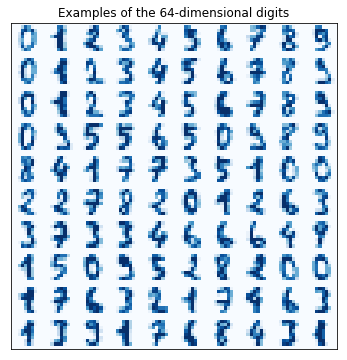

In [9]:
hide_code
img = np.zeros((100, 100))
for i in range(10):
    ix = 10 * i + 1
    for j in range(10):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * 10 + j].reshape((8, 8))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap=plt.cm.Blues)

plt.xticks([])
plt.yticks([])
plt.title('Examples of the 64-dimensional digits');

Computing t-SNE embedding


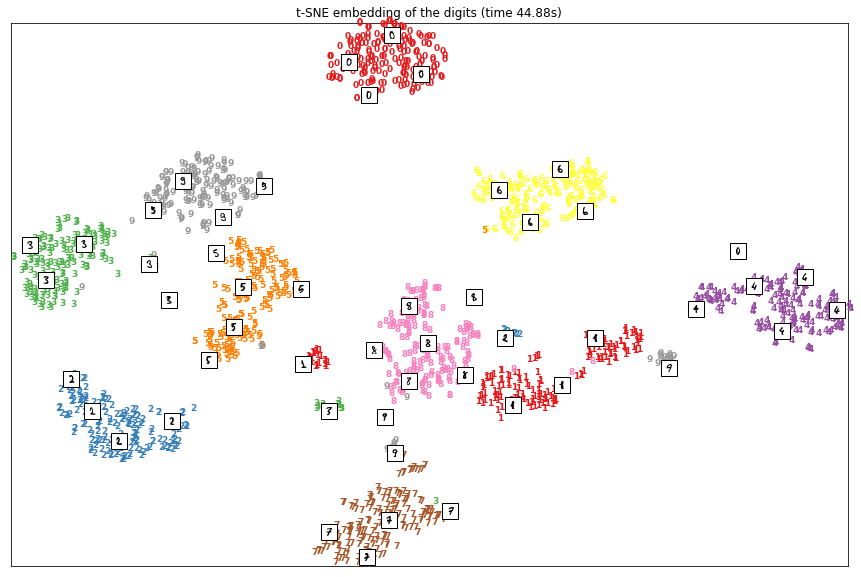

In [11]:
hide_code
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" % (time() - t0))

### Dataset #2. [MNIST](https://www.tensorflow.org/api_docs/python/tf/contrib/keras/datasets/mnist/load_data)

In [12]:
hide_code
mnist_data = mnist.input_data.read_data_sets("MNIST_data/", one_hot=True)
train_images = mnist_data.train.images
train_labels = mnist_data.train.labels
test_images = mnist_data.test.images
test_labels = mnist_data.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
hide_code
print('The second dataset')
print("Shape of the train features - {}, shape of the train target - {}".\
      format(train_images.shape, train_labels.shape))
print("Shape of the test features - {}, shape of the test target - {}".\
      format(test_images.shape, test_labels.shape))

The second dataset
Shape of the train features - (55000, 784), shape of the train target - (55000, 10)
Shape of the test features - (10000, 784), shape of the test target - (10000, 10)


In [14]:
hide_code
print('Reshape features and targets')
# reshape as [samples][width][height]
train_images28 = np.array([np.reshape(x, (28,28)) for x in train_images])
test_images28 = np.array([np.reshape(x, (28,28)) for x in test_images])
# reshape as [samples][pixels][width][height]
train_images_n28 = train_images.reshape(train_images.shape[0], 1, 28, 28).astype('float32')
test_images_n28 = test_images.reshape(test_images.shape[0], 1, 28, 28).astype('float32')
# reshape labels
train_labels2 = np.array([ np.where(r==1)[0][0] for r in train_labels]).reshape(len(train_labels), 1)
test_labels2 = np.array([ np.where(r==1)[0][0] for r in test_labels]).reshape(len(test_labels), 1)

Reshape features and targets


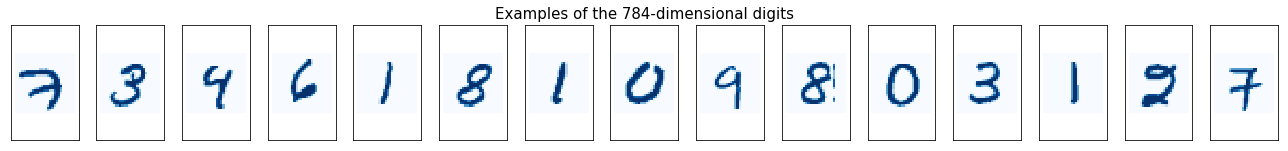

In [15]:
hide_code
fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    image = train_images28[i]
    ax[i].imshow(image, cmap=plt.cm.Blues)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=15);

### Dataset #3. Synthetic. Two digits

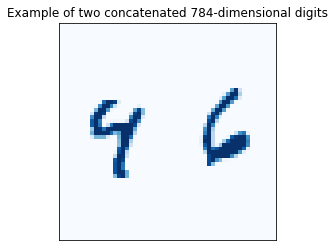

In [16]:
hide_code
image1 = np.concatenate((train_images28[2], train_images28[3]), axis=1)
zero1 = np.zeros((14,56))
image2 = np.concatenate((zero1, image1, zero1), axis=0)
plt.figure(figsize=(4,4))
plt.imshow(image2, cmap=plt.cm.Blues)
plt.xticks([])
plt.yticks([])
plt.title('Example of two concatenated 784-dimensional digits');

In [61]:
hide_code
# Create the third dataset
n1 = int(train_images.shape[0] / 2)
n2 = int(test_images.shape[0] / 2)
h1 = random.randrange(0, 28)
h2 = 28 - h1

train_images28_1 = train_images28[:n1]
train_images28_2 = train_images28[n1:]
test_images28_1 = train_images28[:n2]
test_images28_2 = train_images28[n2:]

train_images56 = [np.concatenate((train_images28_1[i], train_images28_2[i]), axis=1) for i in range(n1)]
train_images56 = np.array([np.concatenate((np.zeros((h1,56)), train_images56[i], 
                                           np.zeros((h2,56))), axis=0) for i in range(n1)])
test_images56 = [np.concatenate((test_images28_1[i], test_images28_2[i]), axis=1) for i in range(n2)]
test_images56 = np.array([np.concatenate((np.zeros((h1,56)), test_images56[i], 
                                          np.zeros((h2,56))), axis=0) for i in range(n2)])

train_images_n56 = train_images56.reshape(-1, 1, 56, 56).astype('float32')
test_images_n56 = test_images56.reshape(-1, 1, 56, 56).astype('float32')

In [62]:
hide_code
train_labels_1 = train_labels2[:n1]
train_labels_2 = train_labels2[n1:]
test_labels_1 = train_labels2[:n2]
test_labels_2 = train_labels2[n2:]

train_labels56 = np.array([np.concatenate((train_labels_1[i], train_labels_2[i])) for i in range(n1)])
test_labels56 = np.array([np.concatenate((test_labels_1[i], test_labels_2[i])) for i in range(n2)])

Example of the third dataset 
[7 0]


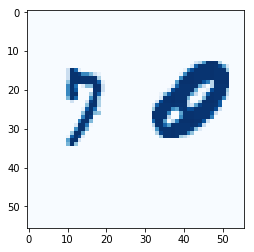

In [63]:
hide_code
print('Example of the third dataset ')
print(test_labels56[25])
plt.imshow(test_images56[25], cmap=plt.cm.Blues);

In [20]:
hide_code
train_labels56_cat1 = ks.utils.to_categorical(train_labels56[:, 0], num_classes=10)
train_labels56_cat2 = ks.utils.to_categorical(train_labels56[:, 1], num_classes=10)

train_labels56_cat = np.concatenate((train_labels56_cat1, train_labels56_cat2), axis=1)
train_labels56_cat = train_labels56_cat.reshape(len(train_labels56_cat), 2, 10)

test_labels56_cat1 = ks.utils.to_categorical(test_labels56[:, 0], num_classes=10)
test_labels56_cat2 = ks.utils.to_categorical(test_labels56[:, 1], num_classes=10)

test_labels56_cat = np.concatenate((test_labels56_cat1, test_labels56_cat2), axis=1)
test_labels56_cat = test_labels56_cat.reshape(len(test_labels56_cat), 2, 10)

In [21]:
hide_code
print('The third dataset')
print("Shape of the train features - {}, shape of the train target - {}".\
      format(train_images56.shape, train_labels56_cat.shape))
print("Shape of the test features - {}, shape of the test target - {}".\
      format(test_images56.shape, test_labels56_cat.shape))

The third dataset
Shape of the train features - (27500, 56, 56), shape of the train target - (27500, 2, 10)
Shape of the test features - (5000, 56, 56), shape of the test target - (5000, 2, 10)


### Dataset #4. Synthetic. Several digits with rotation

In [22]:
hide_code
def rotate_image(image):
        angle = np.random.randint(-15, 15)
        img = scipy.ndimage.interpolation.rotate(image, angle)
        img = scipy.misc.imresize(img, (28, 28))
        rotated_image = scipy.misc.toimage(img)
        return img, rotated_image
    
def fivedigit_label(label):
    size = len(label)
    if size >= 5:
        return label
    else:
        num_zeros = np.full((5-size), 10)
        return np.array(np.concatenate((num_zeros, label), axis = 0))

In [23]:
hide_code
train_rotated28 = np.array([rotate_image(image)[0] for image in train_images28])
test_rotated28 = np.array([rotate_image(image)[0] for image in test_images28])

Example of rotation
[6]


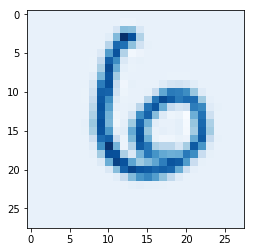

In [24]:
hide_code
plt.imshow(test_rotated28[100], cmap=plt.cm.Blues);
print('Example of rotation')
print(test_labels2[100])

Example of concatenated images
[10  7  3  4  6]


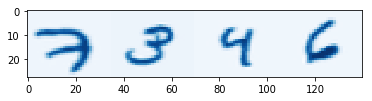

In [25]:
hide_code
image1 = train_rotated28[0]
label1 = train_labels2[0]

for i in range(1, 4):
    image1 = np.concatenate((image1, train_rotated28[i]), axis=1)
    label1 = np.concatenate((label1, train_labels2[i]), axis=0)
    
image1 = scipy.misc.imresize(image1, (28, 28*5))
label1 = fivedigit_label(label1)

plt.imshow(image1, cmap=plt.cm.Blues);
print('Example of concatenated images')
print(label1)

In [26]:
hide_code
def concatenate(images, labels, image_size):
    i = 0
    
    concat_images = np.array(np.zeros((image_size, image_size * 5))).reshape(1, image_size, image_size * 5)
    concat_labels = np.array(np.zeros(5))
    
    while i < images.shape[0]:
        if images.shape[0] - i <= 5: 
            image = images[i] 
            label = labels[i]
            
            for  j  in range(images.shape[0]-i-1): 
                image = np.concatenate((image, images[i+j+1]), axis = 1)
                label = np.concatenate((label, labels[i+j+1]), axis = 0)
                
            label = fivedigit_label(label) 
            image = scipy.misc.imresize(image, (image_size, image_size * 5))
            
            concat_images = np.vstack((concat_images, [image]))
            concat_labels = np.vstack((concat_labels, label))
            
            i = i + 5
            
        else:
            random_n = np.random.randint(3, 6)
            image = images[i]
            label = labels[i]
            
            for k in range(random_n-1):
                image = np.concatenate((image, images[i+k+1]), axis = 1)
                label = np.concatenate((label, labels[i+k+1]), axis = 0)
                
            label = fivedigit_label(label) 
            image = scipy.misc.imresize(image, (image_size, image_size * 5))
            
            concat_images = np.vstack((concat_images, [image]))
            concat_labels = np.vstack((concat_labels, label))
            
            i = i + random_n
            
    concat_images = concat_images[1:]
    concat_labels = concat_labels[1:]

    return concat_images, concat_labels

Example of images concatenated by the function
[ 8.  0.  3.  1.  2.]


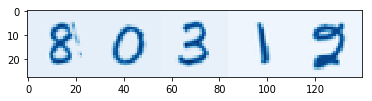

In [27]:
hide_code
img, lbl = concatenate(train_rotated28[:100], train_labels2[:100], 28)
plt.imshow(img[2], cmap=plt.cm.Blues)
print('Example of images concatenated by the function')
print(lbl[2])

In [32]:
hide_code
train_syn_images28, train_syn_labels = concatenate(train_rotated28, train_labels2, 28)

In [33]:
hide_code
test_syn_images28, test_syn_labels = concatenate(test_rotated28, test_labels2, 28)

In [34]:
hide_code
print('The fourth dataset')
print("Shape of the train features - {}, shape of the train target - {}".\
      format(train_syn_images28.shape, train_syn_labels.shape))
print("Shape of the test features - {}, shape of the test target - {}".\
      format(test_syn_images28.shape, test_syn_labels.shape))

The fourth dataset
Shape of the train features - (13713, 28, 140), shape of the train target - (13713, 5)
Shape of the test features - (2488, 28, 140), shape of the test target - (2488, 5)


Example of the final synthetic  datasets
[ 4.  9.  5.  9.  0.]


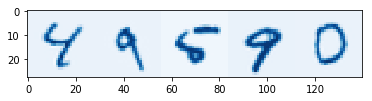

In [35]:
hide_code
plt.imshow(test_syn_images28[2], cmap=plt.cm.Blues);
print('Example of the final synthetic  datasets')
print(test_syn_labels[2])

In [36]:
hide_code
pickle_file = 'concat_mnist.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'train_syn_images': train_syn_images28, 'train_syn_labels': train_syn_labels,
            'test_syn_images': test_syn_images28, 'test_syn_labels': test_syn_labels}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save the data to', pickle_file, ':', e)
    raise

#### Checkpoint 1. Load the synthetic dataset from concat_mnist.pickle

In [68]:
hide_code
pickle_file = 'concat_mnist.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['train_syn_images']
    y_train = save['train_syn_labels']
    X_test = save['test_syn_images']
    y_test = save['test_syn_labels']    
    del save 

In [69]:
hide_code
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])
    
    for i in range(n):
        data_cat[:, i] = ks.utils.to_categorical(data[:, i], num_classes=11)
        
    return data_cat

y_train_cat = digit_to_categorical(y_train)
y_test_cat = digit_to_categorical(y_test)

In [70]:
hide_code
print('Train loaded set', X_train.shape, y_train_cat.shape)
print('Test loaded set', X_test.shape, y_test_cat.shape)

Train loaded set (13713, 28, 140) (13713, 5, 11)
Test loaded set (2488, 28, 140) (2488, 5, 11)


Example of the loaded synthetic  datasets
Digit labels
[ 4.  9.  5.  9.  0.]
Categorical labels
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


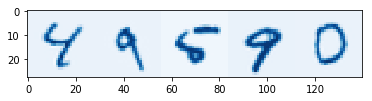

In [71]:
hide_code
plt.imshow(X_test[2], cmap=plt.cm.Blues);
print('Example of the loaded synthetic  datasets')
print('Digit labels')
print(y_test[:][2])
print('Categorical labels')
print(y_test_cat[:][2])

In [72]:
hide_code
train_shape = X_train.shape
X_train = X_train.reshape(-1, 1, train_shape[1], train_shape[2])

test_shape = X_test.shape
X_test = X_test.reshape(-1, 1, test_shape[1], test_shape[2])

y_train_cat_list = [y_train_cat[:, i] for i in range(5)]
y_test_cat_list = [y_test_cat[:, i] for i in range(5)]

print('Reshape the train set for models')
print(X_train.shape, y_train_cat_list[0].shape)
print('Reshape the test set for models')
print(X_test.shape, y_test_cat_list[0].shape)

Reshape the train set for models
(13713, 1, 28, 140) (13713, 11)
Reshape the test set for models
(2488, 1, 28, 140) (2488, 11)


## Step 1: Design and Test a Model Architecture
In this project, we will design and implement a deep learning model that learns to recognize sequences of digits. Also, we will train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, we can, for example, limit ourself to sequences up to five digits, and use five classifiers on top of the deep network. We would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- The model can be derived from a deep neural net or a convolutional network.
- We could experiment sharing or not the weights between the softmax classifiers.
- We can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

We can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an example of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Examples of Models
Models N1 and N2 are classic examples, models N3, N4, N5 and N6 are designed for this project.
#### [Model #1.](https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning)

In [33]:
hide_code
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2

    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:,idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)

                # update weights
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [34]:
hide_code
print('Digit dataset. Rows: %d, columns: %d' % (X.shape[0],X.shape[1]))
nn1 = NeuralNetMLP(n_output=10, n_features=X.shape[1], 
                   n_hidden=128, l2=0.1, l1=0.0, epochs=1000, 
                   eta=0.01, alpha=0.01, decrease_const=0.001,
                   shuffle=True, minibatches=128, random_state=0)
nn1.fit(X, y, print_progress=True);

Epoch: 1/1000

Digit dataset. Rows: 1797, columns: 64


Epoch: 1000/1000

In [35]:
hide_code
y_predict = nn1.predict(X)
y_accuracy = np.sum(y == y_predict, axis=0) / X.shape[0]
print('Train accuracy: %.2f%%' % (y_accuracy * 100))

Train accuracy: 99.78%


In [36]:
hide_code
print('MNIST. Train dataset. Rows: %d, columns: %d' % (train_images.shape[0],train_images.shape[1]))
print('MNIST. Test dataset. Rows: %d, columns: %d' % (test_images.shape[0],test_images.shape[1]))
nn2 = NeuralNetMLP(n_output=10, n_features=train_images.shape[1], 
                   n_hidden=196, l2=0.01, l1=0.0, epochs=1000, 
                   eta=0.001, alpha=0.001, decrease_const=0.00001,
                   shuffle=True, minibatches=50, random_state=1)
nn2.fit(train_images, train_labels2, print_progress=True);

MNIST. Train dataset. Rows: 55000, columns: 784
MNIST. Test dataset. Rows: 10000, columns: 784


Epoch: 1000/1000

In [37]:
hide_code
train_labels_predict = nn2.predict(train_images)
train_accuracy = np.sum(train_labels2[:,0] == train_labels_predict, axis=0) / len(train_labels2)
print('MNIST. Train accuracy: %.2f%%' % (train_accuracy * 100))

test_labels_predict = nn2.predict(test_images)
test_accuracy = np.sum(test_labels2[:,0] == test_labels_predict, axis=0) / len(test_labels2)
print('MNIST. Test accuracy: %.2f%%' % (test_accuracy * 100))

MNIST. Train accuracy: 99.98%
MNIST. Test accuracy: 97.57%


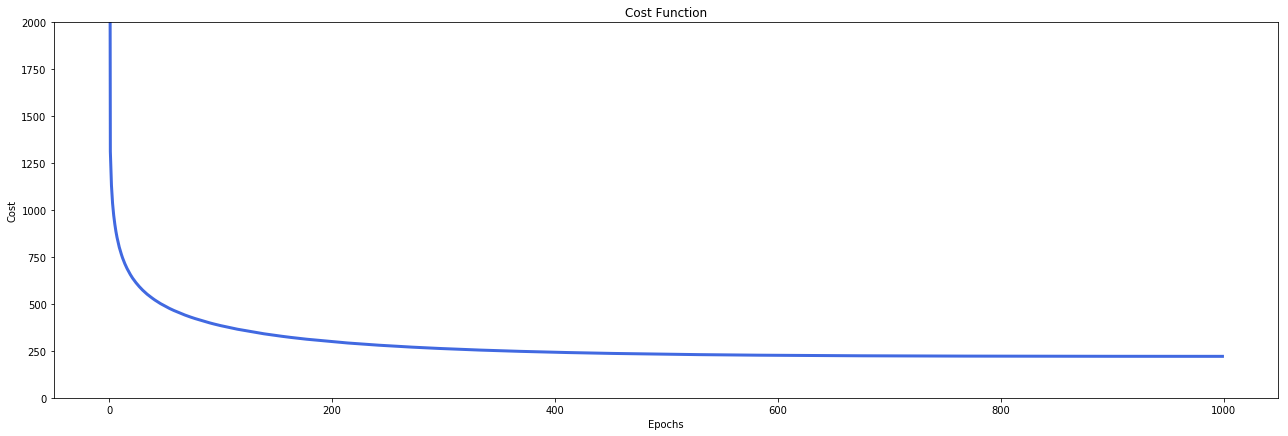

In [38]:
hide_code
batches = np.array_split(range(len(nn2.cost_)), 1000)
cost_ary = np.array(nn2.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.figure(figsize=(18,6))
plt.plot(range(len(cost_avgs)), cost_avgs, lw=3, color='royalblue')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.title('Cost Function');

In [39]:
hide_code
print('Misclassified MNIST images: {}'.format(len(test_images[test_labels2[:,0] != test_labels_predict])))

Misclassified MNIST images: 243


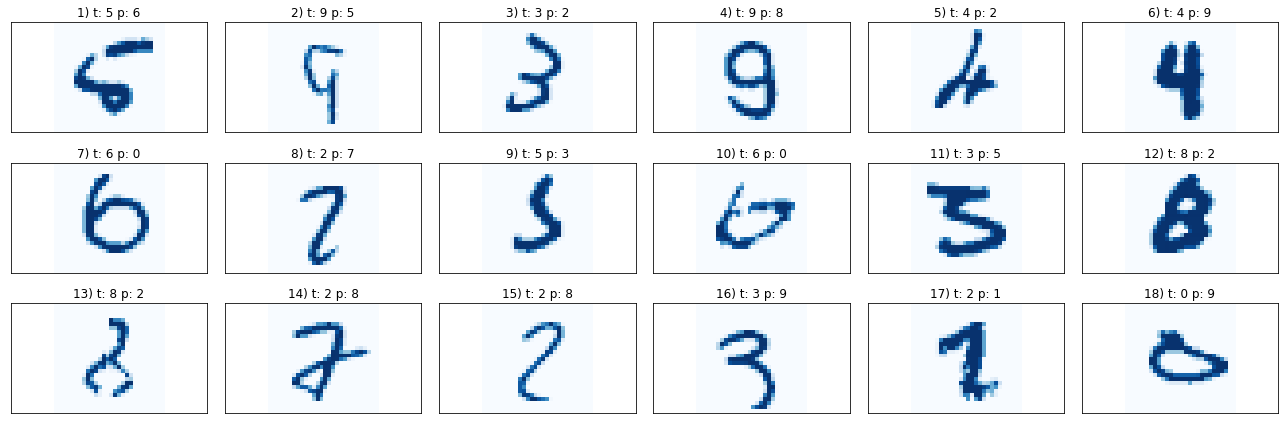

In [40]:
hide_code
miscl_images = test_images[test_labels2[:,0] != test_labels_predict][:18]
correct_labels = test_labels2[test_labels2[:,0] != test_labels_predict][:18]
miscl_labels = test_labels_predict[test_labels2[:,0] != test_labels_predict][:18]

fig, ax = plt.subplots(nrows=3, ncols=6, sharex=True, sharey=True, figsize=(18,6))
ax = ax.flatten()
for i in range(18):
    image = miscl_images[i].reshape(28, 28)
    ax[i].imshow(image, cmap=plt.cm.Blues)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_labels[i], miscl_labels[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

#### [Model #2.](http://cs231n.github.io/neural-networks-case-study/)

In [24]:
hide_code
print('Digit dataset. Rows: %d, columns: %d' % (X.shape[0],X.shape[1]))

Digit dataset. Rows: 1797, columns: 64


In [25]:
hide_code
D1 = 64 # dimensionality
K1 = 10 # number of classes
h1 = 512 # size of hidden layer

W11 = 0.001 * np.random.randn(D1, h1)
b11 = np.zeros((1, h1))
W12 = 0.001 * np.random.randn(h1, K1)
b12 = np.zeros((1, K1))

# some hyperparameters
step_size1 = 1e-2
reg1 = 1e-4 # regularization strength

# gradient descent loop
num_examples1 = X.shape[0]

for i in range(2000): 
    # evaluate class scores
    hidden_layer1 = np.maximum(0, np.dot(X, W11) + b11) # ReLU activation
    scores1 = np.dot(hidden_layer1, W12) + b12
  
    # compute the class probabilities
    exp_scores1 = np.exp(scores1)
    probs1 = exp_scores1 / np.sum(exp_scores1, axis=1, keepdims=True) 
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs1 = -np.log(probs1[range(num_examples1), y])
    data_loss1 = np.sum(corect_logprobs1) / num_examples1
    reg_loss1 = 0.5 * reg1 * np.sum(W11 * W11) + 0.5 * reg1 * np.sum(W12 * W12)
    loss1 = data_loss1 + reg_loss1
    if i % 100 == 0:
        print ("iteration %d: loss %f" % (i, loss1))
  
    # compute the gradient on scores
    dscores1 = probs1
    dscores1[range(num_examples1), y] -= 1
    dscores1 /= num_examples1
  
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW12 = np.dot(hidden_layer1.T, dscores1)
    db12 = np.sum(dscores1, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden1 = np.dot(dscores1, W12.T)
    # backprop the ReLU non-linearity
    dhidden1[hidden_layer1 <= 0] = 0
    # finally into W,b
    dW11 = np.dot(X.T, dhidden1)
    db11 = np.sum(dhidden1, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW12 += reg1 * W12
    dW11 += reg1 * W11
  
    # perform a parameter update
    W11 += -step_size1 * dW11
    b11 += -step_size1 * db11
    W12 += -step_size1 * dW12
    b12 += -step_size1 * db12

iteration 0: loss 2.302590
iteration 100: loss 1.770514
iteration 200: loss 0.521006
iteration 300: loss 0.288663
iteration 400: loss 0.204848
iteration 500: loss 0.161951
iteration 600: loss 0.135860
iteration 700: loss 0.118218
iteration 800: loss 0.105355
iteration 900: loss 0.095443
iteration 1000: loss 0.087490
iteration 1100: loss 0.080901
iteration 1200: loss 0.075286
iteration 1300: loss 0.070396
iteration 1400: loss 0.066070
iteration 1500: loss 0.062201
iteration 1600: loss 0.058705
iteration 1700: loss 0.055526
iteration 1800: loss 0.052621
iteration 1900: loss 0.049954


In [26]:
hide_code
# evaluate training set accuracy
hidden_layer1 = np.maximum(0, np.dot(X, W11) + b11)
scores1 = np.dot(hidden_layer1, W12) + b12
predicted_y = np.argmax(scores1, axis=1)
print ('Digit dataset. Accuracy: %.2f' % (np.mean(predicted_y == y) * 100))

Digit dataset. Accuracy: 99.22


In [27]:
hide_code
print('MNIST. Train dataset. Rows: %d, columns: %d' % (train_images.shape[0], train_images.shape[1]))
print('MNIST. Test dataset. Rows: %d, columns: %d' % (test_images.shape[0], test_images.shape[1]))

MNIST. Train dataset. Rows: 55000, columns: 784
MNIST. Test dataset. Rows: 10000, columns: 784


In [32]:
hide_code
D2 = 784 # dimensionality
K2 = 10 # number of classes
h2 = 196 # size of hidden layer

W21 = 0.001 * np.random.randn(D2, h2)
b21 = np.zeros((1, h2))
W22 = 0.001 * np.random.randn(h2, K2)
b22 = np.zeros((1, K2))

# some hyperparameters
step_size2 = 1e-1
reg2 = 1e-3 # regularization strength

# gradient descent loop
num_examples2 = train_images.shape[0]

for i in range(3000):  
    # evaluate class scores
    hidden_layer2 = np.maximum(0, np.dot(train_images, W21) + b21) # ReLU activation
    scores2 = np.dot(hidden_layer2, W22) + b22
  
    # compute the class probabilities
    exp_scores2 = np.exp(scores2)
    probs2 = exp_scores2 / np.sum(exp_scores2, axis=1, keepdims=True)
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs2 = -np.log(probs2[range(num_examples2), train_labels2[:,0]])
    data_loss2 = np.sum(corect_logprobs2) / num_examples2
    reg_loss2 = 0.5 * reg2 * np.sum(W21 * W21) + 0.5 * reg2 * np.sum(W22 * W22)
    loss2 = data_loss2 + reg_loss2
    if i % 100 == 0:
        print ("iteration %d: loss %f" % (i, loss2))
  
    # compute the gradient on scores
    dscores2 = probs2
    dscores2[range(num_examples2), train_labels2[:,0]] -= 1
    dscores2 /= num_examples2
  
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW22 = np.dot(hidden_layer2.T, dscores2)
    db22 = np.sum(dscores2, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden2 = np.dot(dscores2, W22.T)
    # backprop the ReLU non-linearity
    dhidden2[hidden_layer2 <= 0] = 0
    # finally into W,b
    dW21 = np.dot(train_images.T, dhidden2)
    db21 = np.sum(dhidden2, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW22 += reg2 * W22
    dW21 += reg2 * W21
  
    # perform a parameter update
    W21 += -step_size2 * dW21
    b21 += -step_size2 * db21
    W22 += -step_size2 * dW22
    b22 += -step_size2 * db22   

iteration 0: loss 2.302664
iteration 100: loss 1.936405
iteration 200: loss 0.736582
iteration 300: loss 0.518479
iteration 400: loss 0.442203
iteration 500: loss 0.403756
iteration 600: loss 0.379520
iteration 700: loss 0.362102
iteration 800: loss 0.348492
iteration 900: loss 0.337218
iteration 1000: loss 0.327489
iteration 1100: loss 0.318856
iteration 1200: loss 0.311044
iteration 1300: loss 0.303847
iteration 1400: loss 0.297087
iteration 1500: loss 0.290683
iteration 1600: loss 0.284568
iteration 1700: loss 0.278780
iteration 1800: loss 0.273274
iteration 1900: loss 0.268048
iteration 2000: loss 0.263103
iteration 2100: loss 0.258416
iteration 2200: loss 0.253953
iteration 2300: loss 0.249729
iteration 2400: loss 0.245717
iteration 2500: loss 0.241895
iteration 2600: loss 0.238261
iteration 2700: loss 0.234798
iteration 2800: loss 0.231507
iteration 2900: loss 0.228378


In [33]:
hide_code
# evaluate training set accuracy
hidden_layer2 = np.maximum(0, np.dot(train_images, W21) + b21)
scores2 = np.dot(hidden_layer2, W22) + b22
predicted_train_labels = np.argmax(scores2, axis=1)
print ('MNIST. Train accuracy: %.2f' % (np.mean(predicted_train_labels == train_labels2[:,0]) * 100))

hidden_layer3 = np.maximum(0, np.dot(test_images, W21) + b21)
scores3 = np.dot(hidden_layer3, W22) + b22
predicted_test_labels = np.argmax(scores3, axis=1)
print ('MNIST. Test accuracy: %.2f' % (np.mean(predicted_test_labels == test_labels2[:,0]) * 100))

MNIST. Train accuracy: 95.11
MNIST. Test accuracy: 94.92


#### Model #3. Multi-layer Model. TensorFlow

In [34]:
hide_code
image_size = 28
num_labels = 10
batch_size = 256
hidden_nodes = 784
parameter = 0.0005 
dropout = 0.75

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_images)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights5 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    
    biases1 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases3 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases4 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases5 = tf.Variable(tf.constant(0.05, shape=[num_labels]))
    
    # Training computation with Dropout.   
    train_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), dropout)
    train_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden1, weights2) + biases2), dropout)
    train_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden2, weights3) + biases3), dropout)
    train_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden3, weights4) + biases4), dropout)   
    train_logits = tf.matmul(train_hidden4, weights5) + biases5
    
    test_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), dropout)
    test_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden1, weights2) + biases2), dropout)
    test_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden2, weights3) + biases3), dropout)
    test_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden3, weights4) + biases4), dropout)
    test_logits = tf.matmul(test_hidden4, weights5) + biases5
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) \
    + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2) \
    + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(biases3) \
    + tf.nn.l2_loss(weights4) + tf.nn.l2_loss(biases4) \
    + tf.nn.l2_loss(weights5) + tf.nn.l2_loss(biases5) 
    
    loss += parameter * regularizers    
  
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the train and test sets.
    train_prediction = tf.nn.softmax(train_logits)    
    test_prediction = tf.nn.softmax(test_logits) 

In [35]:
hide_code
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def run_test(num_steps):

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_images[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 300 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [36]:
hide_code
run_test(3001)

Initialized
Minibatch loss at step 0: 3.633366
Minibatch accuracy: 10.9%
Minibatch loss at step 300: 1.608208
Minibatch accuracy: 87.1%
Minibatch loss at step 600: 1.453884
Minibatch accuracy: 91.4%
Minibatch loss at step 900: 1.447759
Minibatch accuracy: 92.6%
Minibatch loss at step 1200: 1.345180
Minibatch accuracy: 93.8%
Minibatch loss at step 1500: 1.259343
Minibatch accuracy: 96.1%
Minibatch loss at step 1800: 1.168974
Minibatch accuracy: 98.8%
Minibatch loss at step 2100: 1.184817
Minibatch accuracy: 96.1%
Minibatch loss at step 2400: 1.151822
Minibatch accuracy: 96.9%
Minibatch loss at step 2700: 1.237523
Minibatch accuracy: 95.3%
Minibatch loss at step 3000: 1.135517
Minibatch accuracy: 98.4%
Test accuracy: 96.0%


#### Model #4. Multi-layer Perceptron. Keras

In [41]:
hide_code
ks.backend.backend()

'tensorflow'

In [44]:
hide_code
def mlp_model():
    model = Sequential()

    model.add(Dense(196, activation='relu', input_dim=784))
    model.add(Dropout(0.1))

    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(10, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

mlp_model = mlp_model()
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp.hdf5', 
                                   verbose=2, save_best_only=True)
mlp_model.fit(train_images, train_labels, 
              validation_data=(test_images, test_labels),
              epochs=20, batch_size=64, verbose=0, callbacks=[mlp_checkpointer]);

Epoch 00000: val_loss improved from inf to 0.18162, saving model to weights.best.mlp.hdf5
Epoch 00001: val_loss improved from 0.18162 to 0.12364, saving model to weights.best.mlp.hdf5
Epoch 00002: val_loss improved from 0.12364 to 0.09678, saving model to weights.best.mlp.hdf5
Epoch 00003: val_loss improved from 0.09678 to 0.08134, saving model to weights.best.mlp.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.08134 to 0.07016, saving model to weights.best.mlp.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.07016 to 0.06824, saving model to weights.best.mlp.hdf5
Epoch 00008: val_loss improved from 0.06824 to 0.06486, saving model to weights.best.mlp.hdf5
Epoch 00009: val_loss improved from 0.06486 to 0.06289, saving model to weights.best.mlp.hdf5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.06289 to 0.06111, saving model to weights.best.mlp.hdf5
Epoch 

In [50]:
hide_code
mlp_model.load_weights('weights.best.mlp.hdf5')
mlp_scores = mlp_model.evaluate(test_images, test_labels, verbose=0)
print("\nMLP Model Scores: ", (mlp_scores))
print("MLP Model Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_model.summary())


MLP Model Scores:  [0.056523545805677713, 0.98309999999999997]
MLP Model Error: 1.69%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 196)               153860    
_________________________________________________________________
dropout_3 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               154448    
_________________________________________________________________
dropout_4 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                7850      
Total params: 316,158
Trainable params: 316,158
Non-trainable params: 0
_________________________________________________________________
None


#### Model #5. Convolutional Neural Network. Keras

In [46]:
hide_code
ks.backend.set_image_dim_ordering('th')

In [47]:
hide_code
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(56, (7, 7), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(28, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = cnn_model()
cnn_checkpointer = ModelCheckpoint(filepath='weights.best.cnn.hdf5', 
                                   verbose=2, save_best_only=True)
cnn_model.fit(train_images_n28, train_labels, 
              validation_data=(test_images_n28, test_labels), 
              epochs=20, batch_size=128, verbose=0, callbacks=[cnn_checkpointer]);

Epoch 00000: val_loss improved from inf to 0.06879, saving model to weights.best.cnn.hdf5
Epoch 00001: val_loss improved from 0.06879 to 0.03953, saving model to weights.best.cnn.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.03953 to 0.03142, saving model to weights.best.cnn.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.03142 to 0.02665, saving model to weights.best.cnn.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.02665 to 0.02628, saving model to weights.best.cnn.hdf5
Epoch 00013: val_loss improved from 0.02628 to 0.02488, saving model to weights.best.cnn.hdf5
Epoch 00014: val_loss improved from 0.02488 to 0.02231, saving model to weights.best.cnn.hdf5
Epoch 00015: val_loss did not improve
Epoc

In [49]:
hide_code
cnn_model.load_weights('weights.best.cnn.hdf5')
cnn_scores = cnn_model.evaluate(test_images_n28, test_labels, verbose=0)

print("CNN Model. Scores: " , (cnn_scores))
print("CNN Model. Error: %.2f%%" % (100 - cnn_scores[1]*100))
print(cnn_model.summary())

CNN Model. Scores:  [0.02230971636336708, 0.99280000000000002]
CNN Model. Error: 0.72%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 22, 22)        2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 11, 11)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 9, 9)          14140     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 4, 4)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 4, 4)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_______________________________________________________

#### Model #6. MLPClassifier. Scikit-learn

In [51]:
hide_code
clf = MLPClassifier(hidden_layer_sizes=(196,), max_iter=50, alpha=1e-4,
                     solver='sgd', verbose=10, tol=1e-4, random_state=1,
                     learning_rate_init=.1)
clf.fit(train_images, train_labels);

Iteration 1, loss = 0.58916377
Iteration 2, loss = 0.25701338
Iteration 3, loss = 0.18989721
Iteration 4, loss = 0.15438474
Iteration 5, loss = 0.13034669
Iteration 6, loss = 0.11081976
Iteration 7, loss = 0.09523089
Iteration 8, loss = 0.08319594
Iteration 9, loss = 0.07444652
Iteration 10, loss = 0.06379925
Iteration 11, loss = 0.05671258
Iteration 12, loss = 0.04889703
Iteration 13, loss = 0.04214241
Iteration 14, loss = 0.03680079
Iteration 15, loss = 0.03191514
Iteration 16, loss = 0.02813514
Iteration 17, loss = 0.02510506
Iteration 18, loss = 0.02122492
Iteration 19, loss = 0.01857865
Iteration 20, loss = 0.01645926
Iteration 21, loss = 0.01486188
Iteration 22, loss = 0.01316782
Iteration 23, loss = 0.01200223
Iteration 24, loss = 0.01049050
Iteration 25, loss = 0.00927723
Iteration 26, loss = 0.00861996
Iteration 27, loss = 0.00803876
Iteration 28, loss = 0.00736086
Iteration 29, loss = 0.00668445
Iteration 30, loss = 0.00632973
Iteration 31, loss = 0.00573149
Iteration 32, los

In [52]:
hide_code
train_predict = clf.predict(train_images)
test_predict = clf.predict(test_images)
print("MNIST. MLP Classifier. Train score: %f" % clf.score(train_images, train_labels))
print("MNIST. MLP Classifier. Test score: %f" % clf.score(test_images, test_labels))

MNIST. MLP Classifier. Train score: 1.000000
MNIST. MLP Classifier. Test score: 0.964100


Visualization of MLP Classifier weights on MNIST


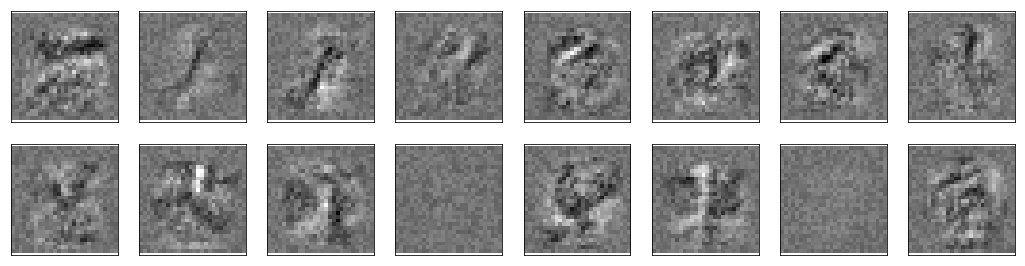

In [54]:
hide_code
print('Visualization of MLP Classifier weights on MNIST')
fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(18, 4.5))

vmin, vmax = clf.coefs_[0].min(), clf.coefs_[0].max()
for coef, ax in zip(clf.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.binary, vmin=0.6*vmin, vmax=0.6*vmax)
    ax.set_xticks(())
    ax.set_yticks(())

### Training the Models Using Synthetic Datasets

#### Synthetic data #3 generated by concatenating character images MNIST

In [65]:
hide_code
def syn3_cnn_model():    
    model_input = Input(shape=(1, 56, 56))    
    x = BatchNormalization()(model_input)
    
    x = Conv2D(56, (3, 3), activation='relu')(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(104, (3, 3), activation='relu')(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    
    x = Dense(208, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(10, activation='softmax')(x)
    y2 = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

syn3_cnn_model = syn3_cnn_model()
syn3_cnn_checkpointer = ModelCheckpoint(filepath='weights.best.syn3_cnn.hdf5', 
                                        verbose=2, save_best_only=True)
syn3_cnn_model.fit(train_images_n56, [train_labels56_cat1, train_labels56_cat2], 
                   validation_data=(test_images_n56, [test_labels56_cat1, test_labels56_cat2]), 
                   epochs=10, batch_size=128, verbose=0, callbacks=[syn3_cnn_checkpointer]);

Epoch 00000: val_loss improved from inf to 0.47408, saving model to weights.best.syn3_cnn.hdf5
Epoch 00001: val_loss improved from 0.47408 to 0.16927, saving model to weights.best.syn3_cnn.hdf5
Epoch 00002: val_loss improved from 0.16927 to 0.11986, saving model to weights.best.syn3_cnn.hdf5
Epoch 00003: val_loss improved from 0.11986 to 0.10832, saving model to weights.best.syn3_cnn.hdf5
Epoch 00004: val_loss improved from 0.10832 to 0.09518, saving model to weights.best.syn3_cnn.hdf5
Epoch 00005: val_loss improved from 0.09518 to 0.08339, saving model to weights.best.syn3_cnn.hdf5
Epoch 00006: val_loss improved from 0.08339 to 0.07879, saving model to weights.best.syn3_cnn.hdf5
Epoch 00007: val_loss improved from 0.07879 to 0.07480, saving model to weights.best.syn3_cnn.hdf5
Epoch 00008: val_loss improved from 0.07480 to 0.06802, saving model to weights.best.syn3_cnn.hdf5
Epoch 00009: val_loss improved from 0.06802 to 0.06046, saving model to weights.best.syn3_cnn.hdf5


In [66]:
hide_code
syn3_cnn_model.load_weights('weights.best.syn3_cnn.hdf5')
syn3_cnn_scores = syn3_cnn_model.evaluate(test_images_n56, 
                                          [test_labels56_cat1, test_labels56_cat2], 
                                          verbose=0)
print("CNN. Synthetic Data #3")
print("Scores: " , (syn3_cnn_scores))
print("First digit. Accuracy: %.2f%%" % (syn3_cnn_scores[3]*100))
print("Second digit. Accuracy: %.2f%%" % (syn3_cnn_scores[4]*100))

print(syn3_cnn_model.summary())

syn3_avg_accuracy = sum([syn3_cnn_scores[i] for i in range(3, 5)])/2
print("\nAverage Accuracy: %.2f%%" % (syn3_avg_accuracy*100))

CNN. Synthetic Data #3
Scores:  [0.060461320305988192, 0.027531224164180457, 0.032930095807509496, 0.99099999999999999, 0.98960000000000004]
First digit. Accuracy: 99.10%
Second digit. Accuracy: 98.96%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1, 56, 56)     0                                            
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 1, 56, 56)     224         input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 56, 54, 54)    560         batch_normalization_4[0][0]      
___________________________________________________________________________________________

#### Synthetic data #4 generated by concatenating and rotating character images MNIST

In [73]:
hide_code
def syn4_cnn_model():    
    model_input = Input(shape=(1, 28, 140))   
    x = BatchNormalization()(model_input)
    
    x = Conv2D(28, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(28, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Dropout(0.2)(x)
    
    x = Conv2D(56, kernel_size=(3, 3), activation='relu')(x)
    x = Conv2D(56, kernel_size=(3, 3), activation='relu')(x)
    
    x = Dropout(0.2)(x)
              
    x = Flatten()(x)
    
    x = Dense(784, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2, y3, y4, y5])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

syn4_cnn_model = syn4_cnn_model()
syn4_cnn_checkpointer = ModelCheckpoint(filepath='weights.best.syn4_cnn.hdf5', 
                                        verbose=2, save_best_only=True)
syn4_cnn_model.fit(X_train, y_train_cat_list, 
                   validation_data=(X_test, y_test_cat_list), 
                   epochs=20, batch_size=128, verbose=0, callbacks=[syn4_cnn_checkpointer]);

Epoch 00000: val_loss improved from inf to 2.27583, saving model to weights.best.syn4_cnn.hdf5
Epoch 00001: val_loss improved from 2.27583 to 0.75202, saving model to weights.best.syn4_cnn.hdf5
Epoch 00002: val_loss improved from 0.75202 to 0.53179, saving model to weights.best.syn4_cnn.hdf5
Epoch 00003: val_loss improved from 0.53179 to 0.40458, saving model to weights.best.syn4_cnn.hdf5
Epoch 00004: val_loss improved from 0.40458 to 0.38451, saving model to weights.best.syn4_cnn.hdf5
Epoch 00005: val_loss improved from 0.38451 to 0.35048, saving model to weights.best.syn4_cnn.hdf5
Epoch 00006: val_loss improved from 0.35048 to 0.32545, saving model to weights.best.syn4_cnn.hdf5
Epoch 00007: val_loss improved from 0.32545 to 0.32143, saving model to weights.best.syn4_cnn.hdf5
Epoch 00008: val_loss improved from 0.32143 to 0.29785, saving model to weights.best.syn4_cnn.hdf5
Epoch 00009: val_loss improved from 0.29785 to 0.27466, saving model to weights.best.syn4_cnn.hdf5
Epoch 00010: v

In [74]:
hide_code
syn4_cnn_model.load_weights('weights.best.syn4_cnn.hdf5')
syn4_cnn_scores = syn4_cnn_model.evaluate(X_test, y_test_cat_list, verbose=0)

print("CNN. Synthetic Data #4")
print("Scores: " , (syn4_cnn_scores))
print("First digit. Accuracy: %.2f%%" % (syn4_cnn_scores[6]*100))
print("Second digit. Accuracy: %.2f%%" % (syn4_cnn_scores[7]*100))
print("Third digit. Accuracy: %.2f%%" % (syn4_cnn_scores[8]*100))
print("Fourth digit. Accuracy: %.2f%%" % (syn4_cnn_scores[9]*100))
print("Fifth digit. Accuracy: %.2f%%" % (syn4_cnn_scores[10]*100))

print(syn4_cnn_model.summary())

syn4_avg_accuracy = sum([syn4_cnn_scores[i] for i in range(6, 11)])/5
print("Average Accuracy: %.2f%%" % (syn4_avg_accuracy*100))

CNN. Synthetic Data #4
Scores:  [0.26882896312719085, 0.019526977618821034, 0.036307981134232954, 0.084684391122098357, 0.052093008615097504, 0.076216603154821413, 0.99437299035369775, 0.98995176829709119, 0.97789389067524113, 0.9863344051446945, 0.98030546623794212]
First digit. Accuracy: 99.44%
Second digit. Accuracy: 99.00%
Third digit. Accuracy: 97.79%
Fourth digit. Accuracy: 98.63%
Fifth digit. Accuracy: 98.03%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1, 28, 140)    0                                            
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 1, 28, 140)    560         input_6[0][0]                    
___________________________________________________________________________

## Questions and Answers

### Question 1
_What approach did you take in coming up with a solution to this problem?_
### Answer 1
At first, I found out the information about classic examples of the data with handwritten digits and the models of neural networks. 

Then, I tried to  build several models. In the construction process, I used the most convenient resources for Python: 'Scikit-Learn', 'TensorFlow', and 'Keras'.

Finally, for reasons of simplicity and quickness of construction, as well as effectiveness and accuracy of predictions, I chose 'Keras' as a programming library and the convolutional neural network as a type of the model.

---

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_
### Answer 2

Fortunately, It's very easy to display and describe the architecture of the CNN with the function model.summary().

- *Type*: Convolutional Neural Network.
- *Layers*:
  - `InputLayer` (input_2, [1, 28, 140]) holds the raw pixel values of the image with width 140, height 28, and 1 color channel. 
  - `BatchNormalization` layer (batch_normalization_6, [1, 28, 140]) normalizes the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. This step leaves the size of the volume unchanged [1, 28, 140] -> [1, 28, 140].
  - `Conv2D` layers [(conv2d_12, [28, 26, 138]), (conv2d_13, [28, 11, 67]), (conv2d_14, [56, 3, 31]), (conv2d_15, [56, 1, 29])]  compute the output of neurons that are connected to local regions in the input each computing a dot product between their weights and a small region they are connected to in the input volume. This results in the volume such as [28, 140, 1] -> [28, 140, 28] when it was used 28 filters.
  - `relu` activation applies an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged [28, 26, 138] -> [28, 26, 138].
  - `MaxPooling2D` layers [(max_pooling2d_9, [28, 13, 69]), (max_pooling2d_10, [28, 5, 33])] perform a downsampling operation along the spatial dimensions (width, height). Max-pooling partitions the input image into a set of non-overlapping rectangles and, for each such subregion, outputs the maximum value. This results in the volume such as [28, 140, 28] -> [14, 70, 28].
  - `Dropout` layers [(dropout_12, [28, 5, 33]), (dropout_13, [56, 1, 29]), (dropout_14, [784])] consist in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. This leaves the size of the volume unchanged [56, 1, 29] -> [56, 1, 29].
  - `Dense` (fully connected) layers [(dense_19, [784]), (dense_20, [11], (dense_21, [11], (dense_22, [11], (dense_23, [11], (dense_24, [11]) compute the class scores, resulting in volume of size. For example, the size [11] corresponds to class scores, such as 10 digits and 1 empty place. Each neuron in these layers are connected to all the numbers in the previous volume.
  - `softmax` activation applies an activation function (logistic regression) and outputs a separate probability for each of 11 classes. This leaves the size of the volume unchanged [11] -> [11].
  - `Flatten` layer (flatten_4, [1624]) flattens the input and collapses it into the one-dimensional feature vector. This results in the volume such as [56, 1, 29] -> [1624].
---

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.
### Answer 3
The synthetic dataset was generated by concatenating in one image some digit symbols (from 1 to 5) with rotation. 

Each step was reflected by displaying constructed images. 

It was built from the original data `MNIST` of handwritten digits. 

Then the synthetic data were divided into training and testing sets. 

And the model was trained and tested with following parameters:

- epochs - 20,
- batch size - 128.